In [100]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [101]:
#import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [102]:

Nx=32
Ny=32

Lx= 30
Ly= 30
T_end = 1
dt = 0.005

myubatch_size = 32768
myu=4
path = f"main-N-{Nx}-L-{Lx}-Myu-{myu}-new-approach"
mtlibpath_prefix = path + "_mtl"

input_to_defect_ratio_sqrt = Nx // myu
N_ITERATIONS = int(T_end / dt)
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=50, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|██████████| 200/200 [00:00<00:00, 4329.85it/s]

Unique Myus count	 64
Max value of myu:	 98.85197228271444
Min value of myu:	 31.88124086517815
Unique values: [31.88124086517815, 37.359270372192285, 38.2547862344231, 40.403393621893414, 43.05756207168323, 43.24760846995792, 43.753363670372714, 45.05815969328097, 45.987733413536446, 47.076814165092564, 47.58720219369401, 48.67068120615301, 49.24367785201386, 49.28524332778978, 49.33108518051292, 50.32473718921847, 51.443946669041416, 51.80089933009744, 52.02602883875635, 53.53632954870041, 54.6829986222362, 55.14987205756386, 55.43562266557849, 56.20676905089182, 57.06839060892531, 57.90650138957515, 58.685425924785875, 58.796727812331405, 59.781833841923536, 60.392704947691506, 60.62820430629501, 60.752503108835015, 60.922866128937116, 61.43770738474606, 61.48702528832784, 62.54631333935813, 63.17850079341826, 64.51404848902129, 64.88013229482216, 65.00817838529062, 66.26218339532609, 66.52395340558455, 68.17196198382413, 72.46314655157941, 73.32744083352007, 74.15451752168602, 74.2

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [103]:
x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [104]:
class ALLINPUTNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(ALLINPUTNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim = -1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2, dim = 1)
        return torch.mean(torch.sqrt(mseloss))   

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2)       

    def y_proc(y):
        MS = y[:,1] * y[:,0]
        IR = y[:,1] ** 2 +  y[:,0] ** 2
        return torch.vstack((MS,IR)).T
    

    def fastbatchtrain(self, x, y_proc, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y_proc = torch.tensor(y_proc, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y_proc)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    
                    loss = self.msef(ALLINPUTNET.y_proc(y_pred),U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L

In [105]:
class ALLINPUTPINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(ALLINPUTPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        self._Wtmx.register_parameter('myu', myu)
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,x):
        myuloss = MYULOSS(*tuple(x.T),self)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [106]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.net = net
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        x,y,t = self.x, self.y, self.t
        
        u, u_t,u_xx,u_yy = MYULOSS.pref(x,y,t,net)
        
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        free_memory(u_t, u_xx, u_yy, u, f_withoutmyu)

    
  def f_withoutmyu(x,y,t,ru,iu):
        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j)
        u_t = (ru_t + iu_t * 1j)
        u_xx =( ru_xx + iu_xx *1j)
        u_yy = (ru_yy + iu_yy *1j)
        
        return u, u_t,u_xx,u_yy
    
  def pref(x,y,t, net, batch_size = myubatch_size):
    dataloader = DataLoader(dataset = X_star, batch_size = batch_size, shuffle=False)
    cache = {
        'u':[],
        'u_t':[],
        'u_xx':[],
        'u_yy':[],
    }
    for tmp in tqdm(dataloader):
        x,y,t = torch.tensor(tmp.T, dtype = torch.float64, requires_grad=True).to(device)
        ru,iu = net.forward(torch.stack((x,y,t)).T).T
        u, u_t,u_xx,u_yy = MYULOSS.f_withoutmyu(x,y,t,ru,iu)
        cache['u'].append(u.cpu().detach())
        cache['u_t'].append(u_t.cpu().detach())
        cache['u_xx'].append(u_xx.cpu().detach())
        cache['u_yy'].append(u_yy.cpu().detach())
        
    return  torch.cat(cache['u']).view(mem_rate, Nx, Ny), \
            torch.cat(cache['u_t']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_xx']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_yy']).view(mem_rate, Nx, Ny)

      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [107]:
torch.manual_seed(0)
device = 'cpu'
net = ALLINPUTPINN([3,8,32,64,32,8,2]).to(device)

In [108]:
u_star_proc = ALLINPUTNET.y_proc(torch.tensor(u_star, dtype = torch.float64).to(device))
L1 = net.fastbatchtrain(x = X_star, y_proc = u_star_proc, epochs = 100000)

100%|██████████| 100000/100000 [02:09<00:00, 771.80it/s]


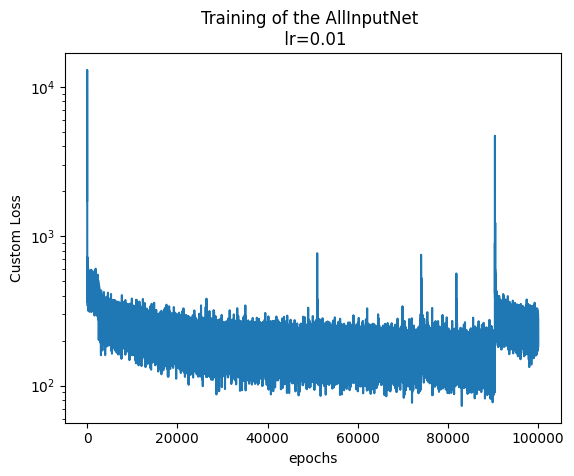

In [109]:
plt.plot(L1)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.01')
plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')

In [110]:
net.optimizer.param_groups[0]['lr'] = 0.001
L2 = net.fastbatchtrain(x = X_star, y_proc = u_star_proc, epochs = 100000)

100%|██████████| 100000/100000 [02:09<00:00, 770.75it/s]


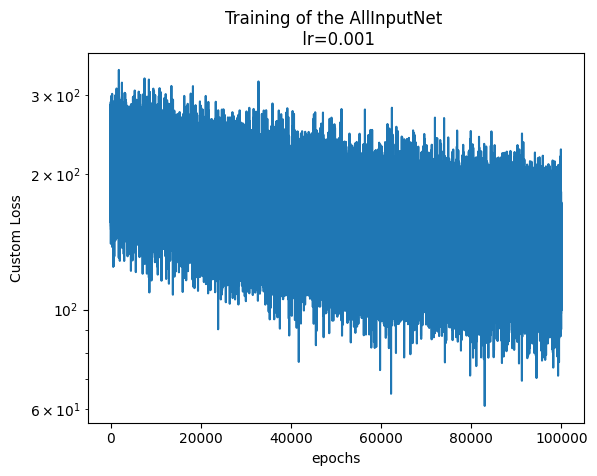

In [111]:
plt.plot(L2)
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Custom Loss')
plt.title('Training of the AllInputNet \n lr=0.001')
plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')

## calculating myus

In [112]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.loaddata_precalculate(X_star)
net.myureset()

100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


100%|██████████| 10/10 [00:00<00:00, 246.07it/s]


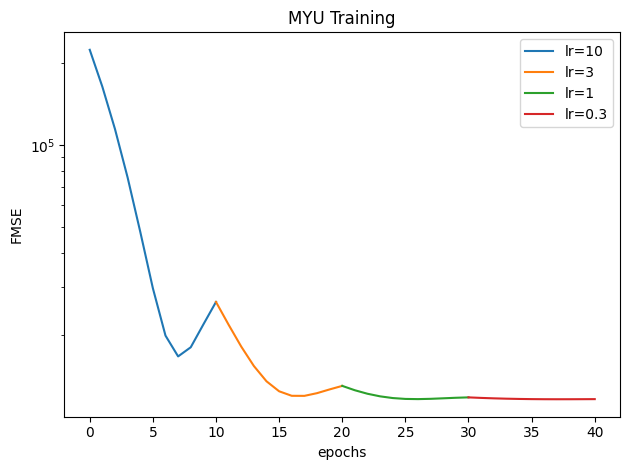

In [113]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.myureset()

i = 0
for lr in [10, 3, 1, 0.3]:
    L = net.myutrain(lr=lr, epochs=10)
    l = net.fmse().cpu().detach().numpy()
    L += [l]
    net.myuloss.clear()
 
    plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
    i+=len(L)-1

plt.yscale('log')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('FMSE')
plt.title('MYU Training')
plt.tight_layout()
plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
plt.show()

## Visualizing and saving plot gifs

In [114]:
def process_frame(index, u_im_real, o_im_real, phase,  title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Display the u_pred image
    im1 = axs[0].imshow(u_im_real[index])
    axs[0].set_title(title + " (u_pred) without normalization" + f" - Frame: {index}")
    axs[0].title.set_position([.5, 1.05])
    
    # Display the original image
    im2 = axs[1].imshow(o_im_real[index])
    axs[1].set_title(title + " (original) without normalization" + f" - Frame: {index}")
    axs[1].title.set_position([.5, 1.05])
    
    # Display the difference image
    im3 = axs[2].imshow(np.abs(u_im_real[index] - o_im_real[index]))
    axs[2].set_title(title + " (difference) without normalization" + f" - Frame: {index}")
    axs[2].title.set_position([.5, 1.05])
    
    # Add colorbars
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
    
    # Draw the figure and store the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    
    return image

In [115]:
def process_subframe(fig, ax, m, title):
    
    im = ax.imshow(m)
    ax.title.set_position([.5, 1.05])
    im = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    
def process_frame(M, titles):
    figsize = (M.shape[0], M.shape[1])
    fig, axs = plt.subplots(*figsize, figsize=(18, 6))
    
    # Draw
    for i in range(figsize[0]):
        for j in range(figsize[1]):
            ax = axs[i][j]
            process_subframe(fig,axs[i][j], M[i][j],titles[i][j])
            
    # Draw the figure and store the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    
    return image   

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    num_cores = multiprocessing.cpu_count()
#    images = Parallel(n_jobs=num_cores)(delayed(process_frame)((m,titles) for m in tqdm(M)))
    images = [process_frame(m,titles) for m in M]
    if save:
        images_to_video(images, videotitle, fps=30)
        print("Video successfully saved at", videotitle)
    
    return None

def create_video(M,titles, videotitle, save=True, fps=30):
    
    
    images = [process_frame(m,titles) for m in M]
    #Parallel(n_jobs=num_cores)(delayed(process_frame)(m, titles) for m in tqdm(M))
    if save:
        # Convert images to 8-bit color for video
        images = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in images]
        height, width, _ = images[0].shape
        video = cv2.VideoWriter(videotitle, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        for img in images:
            video.write(img)
        video.release()
        print("Video successfully saved at", videotitle)
    
    return None

In [116]:
from __future__ import annotations
import cv2
import torch
import imageio
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Optional
from joblib import Parallel, delayed
from torch.nn.parameter import Parameter
from IPython.display import display, Image



In [117]:
module_sq = lambda a: np.real(a)**2 + np.imag(a)**2
phase = lambda a: np.arcsin(np.real(a)/np.sqrt(np.real(a)**2+np.imag(a)**2))
real_imag = lambda a: np.real(a)*np.imag(a)
real = lambda a: np.real(a)
imag = lambda a: np.imag(a)

funlist_name = ["module_sq", "phase", "real_imag", "real", "imag"]
funlist = [module_sq, phase, real_imag, real, imag]

myu = myu_original[0]
myupred = net.myu.cpu().detach().numpy()

A_pred = net.predict(X_star).reshape(A_original[0].shape)

In [118]:
ATenzor = np.array([np.stack([np.stack([fun(A) for fun in funlist]),
                    np.stack([fun(Ap) for fun in funlist])]) for A, Ap in zip(A_original[0], A_pred)])

In [119]:
MTenzor = np.array([np.array([m,mp]) for m, mp in zip(myu,myupred)])

In [120]:
AMTenzor = np.concatenate((MTenzor[:, :, np.newaxis, :, :], ATenzor), axis=2)

In [121]:
create_video(AMTenzor, titles=[['myu'] + funlist_name]*2, videotitle = path + '.mp4')

Video successfully saved at main-N-32-L-30-Myu-4-new-approach.mp4
